In [1]:

%cd './RerankingTransformer/RRT_SOP'

import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import NamedTuple, Optional

from torch.utils.data import DataLoader, RandomSampler, BatchSampler

import os, math
import os.path as osp
from copy import deepcopy
from functools import partial
from pprint import pprint

import torch
import torch.nn as nn
from torch.backends import cudnn

from utils import pickle_load, pickle_save
from utils.data.dataset_ingredient import data_ingredient, get_loaders
from models.ingredient import model_ingredient, get_model
from utils.training import evaluate_global


import os.path as osp
from typing import NamedTuple, Optional

# from sacred import Ingredient
from torch.utils.data import DataLoader, RandomSampler, BatchSampler
from torchvision import transforms


/home/ec2-user/environment/W210-Capstone-Project/RerankingTransformer/RRT_SOP


In [2]:
%pwd

'/home/ec2-user/environment/W210-Capstone-Project/RerankingTransformer/RRT_SOP'

In [3]:
from random import sample, choices
from typing import Union, List

import torch
from PIL import Image
from torch.utils.data import Sampler
from torchvision.transforms import functional as F

import pickle, json


def pickle_load(path):
    with open(path, 'rb') as fid:
        data_ = pickle.load(fid)
    return data_


def pickle_save(path, data):
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)


def json_load(path):
    with open(path, 'r') as fid:
        data_ = json.load(fid)
    return data_


def json_save(path, data):
    with open(path, 'w') as fid:
        json.dump(data, fid, indent=4, sort_keys=True)
###############################################################


class RandomReplacedIdentitySampler(Sampler):
    def __init__(self, 
            labels: Union[List[int], torch.Tensor], batch_size: int, 
            num_identities: int, num_iterations: int):
        self.num_identities = num_identities
        self.num_iterations = num_iterations
        self.samples_per_id = batch_size // num_identities
        self.labels = torch.as_tensor(labels, dtype=torch.long)
        self.counts = torch.bincount(self.labels)
        self.label_indices = [torch.nonzero(self.labels == i, as_tuple=False).squeeze(1).tolist() for i in range(len(self.counts))]

    def __len__(self):
        return self.num_iterations

    def __iter__(self):
        possible_ids = [i for i in range(len(self.label_indices)) if len(self.label_indices[i]) >= self.samples_per_id]

        for i in range(self.num_iterations):
            batch = []
            selected_ids = sample(possible_ids, k=self.num_identities)
            for s_id in selected_ids:
                batch.extend(sample(self.label_indices[s_id], k=self.samples_per_id))
            yield batch


class TripletSampler():
    def __init__(self, labels, batch_size, cache_nn_inds):
        self.num_samples = len(labels)
        self.batch_size = batch_size
        self.labels = torch.as_tensor(labels, dtype=torch.long)
        self.counts = torch.bincount(self.labels)
        self.cache_nn_inds = pickle_load(cache_nn_inds)
        self.label_indices = [torch.nonzero(self.labels == i, as_tuple=False).squeeze(1).tolist() for i in range(len(self.counts))]

    def __iter__(self):
        batch = []
        cands = torch.randperm(self.num_samples).tolist()
        for i in range(self.num_samples):
            idx = cands[i]
            current_label = self.labels[idx]
            topk_inds = self.cache_nn_inds[idx, :100]
            positive_inds = [ni for ni in self.label_indices[current_label] if ni != idx]
            negative_inds = [ni for ni in topk_inds if self.labels[ni] != current_label]
            # if len(positive_inds) == 0:
            #     positive_inds = [ni for ni in self.label_indices[current_label] if ni != idx]
            assert(len(positive_inds) > 0)
            assert(len(negative_inds) > 0)

            batch.append(idx)
            pid = choices(positive_inds)[0]
            nid = choices(negative_inds)[0]
            batch.append(pid) 
            batch.append(nid)

            if len(batch) >= self.batch_size:
                yield batch
                batch = []
                
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return (self.num_samples * 3 + self.batch_size - 1) // self.batch_size

In [4]:
from PIL import Image
from torch.utils.data import Dataset


class ImageDataset(Dataset):
    def __init__(self, samples: list, transform):
        self.transform = transform

        self.categories = sorted(list(set([entry[1] for entry in samples])))
        self.cat_to_label = dict(zip(self.categories, range(len(self.categories))))
        self.samples = [(path, self.cat_to_label[cat]) for path, cat in samples]
        self.targets = [label for _, label in self.samples]
  
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path, label = self.samples[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label, index

In [5]:
# configs
name = 'sop'
data_path = './data/Stanford_Online_Products'
train_file = 'train.txt'
test_file = 'test.txt' # modified to test_sample

batch_size = 128
sample_per_id = 2
assert (batch_size % sample_per_id == 0)
test_batch_size = 1 # can change to 1
sampler = 'random'

num_workers = 8  
pin_memory = True

crop_size = 224
recalls = [1, 10, 100, 1000]

num_identities = batch_size // sample_per_id 
num_iterations = 59551 // batch_size

train_cache_nn_inds  = None
test_cache_nn_inds   = None


# model configs
arch = 'resnet50'
pretrained = True  # use a pretrained model from torchvision
dropout = 0.
norm_layer = None  # use a normalization layer (batchnorm or layernorm) for the features
remap = False  # remap features through a linear layer
detach = False  # detach features before feeding to the classification layer. Prevents training of the feature extractor with cross-entropy.
normalize = False  # normalize the features
set_bn_eval = True  # set bn in eval mode even in training
normalize_weight = False  # normalize the weights of the classification layer
freeze_backbone = False
###############################
num_global_features = 128  # dimensionality of the features produced by the feature extractor
num_local_features = 128
###############################
## Encoder from Transformer (ERT)
ert_seq_len=102
ert_dim_feedforward=1024
ert_nhead=4
ert_num_encoder_layers=6
ert_dropout=0.0 
ert_activation="relu"
ert_normalize_before=False

# more configs
cpu = False 
cudnn_flag = 'benchmark'
temp_dir = os.path.join('outputs', 'temp')
seed = 0
resume = None
query_set = 'test'

In [6]:
def get_transforms(crop_size):
    train_transform, test_transform = [], []
    train_transform.extend([
        transforms.RandomResizedCrop(size=crop_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()])
    test_transform.append(transforms.Resize((256, 256)))
    test_transform.append(transforms.CenterCrop(size=224))
    # start using new code
    # test_transform.append(transforms.RandomPerspective(distortion_scale=0.5, p=1, interpolation=3, fill=0)) # auto contrast each image
    # test_transform.append(transforms.Grayscale(num_output_channels=1))
    # test_transform.append(transforms.ColorJitter(contrast = [2,2.01]))
    # end using new code
    test_transform.append(transforms.ToTensor())
    return transforms.Compose(train_transform), transforms.Compose(test_transform)

In [7]:
def read_file(filename):
    with open(filename) as f:
        lines = f.read().splitlines()
    return lines

In [8]:
def get_sets(name, data_path, train_file, test_file, num_workers):
    train_transform, test_transform = get_transforms(crop_size = crop_size)

    train_lines = read_file(osp.join(data_path, train_file))
    train_samples = [(osp.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in train_lines]
    train_set = ImageDataset(train_samples, transform=train_transform)
    query_train_set = ImageDataset(train_samples, transform=test_transform)

    if isinstance(test_file, list) and len(test_file) == 2:
        query_lines   = read_file(osp.join(data_path, test_file[0]))
        gallery_lines = read_file(osp.join(data_path, test_file[1]))
        query_samples   = [(osp.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in query_lines]
        gallery_samples = [(osp.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in gallery_lines]
        query_set   = ImageDataset(query_samples,   transform=test_transform)
        gallery_set = ImageDataset(gallery_samples, transform=test_transform)
    else:
        query_lines   = read_file(osp.join(data_path, test_file))
        query_samples = [(osp.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in query_lines]
        query_set = ImageDataset(query_samples, transform=test_transform)
        gallery_set = None

    return (train_set, query_train_set), (query_set, gallery_set)

In [9]:
class MetricLoaders(NamedTuple):
    train: DataLoader
    num_classes: int
    query: DataLoader
    query_train: DataLoader
    gallery: Optional[DataLoader] = None

In [10]:
# get_loaders function
def get_loaders(batch_size, test_batch_size, 
        num_workers, pin_memory, 
        sampler, recalls,
        num_iterations=None, 
        num_identities=None,
        train_cache_nn_inds=None,
        test_cache_nn_inds=None):

    (train_set, query_train_set), (query_set, gallery_set) = get_sets(name = name,
                                                                      data_path = data_path,
                                                                      train_file = train_file,
                                                                      test_file = test_file,
                                                                      num_workers = num_workers)

    if sampler == 'random':
        train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=True)
    elif sampler == 'triplet':
        if train_cache_nn_inds and osp.exists(train_cache_nn_inds):
            train_sampler = TripletSampler(train_set.targets, batch_size, train_cache_nn_inds)
        else:
            # For evaluation only
            train_sampler = None
    elif sampler == 'random_id':
        train_sampler = RandomReplacedIdentitySampler(train_set.targets, batch_size, 
            num_identities=num_identities, num_iterations=num_iterations)
    else:
        raise ValueError('Invalid choice of sampler ({}).'.format(sampler))
    train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    query_train_loader = DataLoader(query_train_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    query_loader = DataLoader(query_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    gallery_loader = None
    if gallery_set is not None:
        gallery_loader = DataLoader(gallery_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)

    return MetricLoaders(train=train_loader, query_train=query_train_loader, query=query_loader, gallery=gallery_loader, num_classes=max(train_set.targets) + 1), recalls

In [11]:
# get model (recreate from rrt)

loaders, recall_ks = get_loaders(batch_size = batch_size, test_batch_size = test_batch_size, 
        num_workers = num_workers, pin_memory = pin_memory, 
        sampler = sampler, recalls = recalls,
        num_iterations=None, 
        num_identities=None,
        train_cache_nn_inds=None,
        test_cache_nn_inds=None)


model = get_model(num_classes=loaders.num_classes,
                  arch = arch, 
                  pretrained = pretrained, 
                  num_global_features = num_global_features, 
                  norm_layer = norm_layer, 
                  detach = detach, 
                  remap = remap, 
                  normalize = normalize, 
                  normalize_weight = normalize_weight, 
                  set_bn_eval = set_bn_eval, 
                  dropout = dropout, 
                  num_local_features = num_local_features, 
                  freeze_backbone = freeze_backbone,
                  ert_seq_len = ert_seq_len,
                  ert_dim_feedforward = ert_dim_feedforward,
                  ert_nhead = ert_nhead,
                  ert_num_encoder_layers = ert_num_encoder_layers,
                  ert_dropout = ert_dropout,
                  ert_activation = ert_activation,
                  ert_normalize_before = ert_normalize_before)

# model = torch.load('./RerankingTransformer/RRT_SOP/rrt_sop_ckpts/rrt_r50_sop_global.pt')

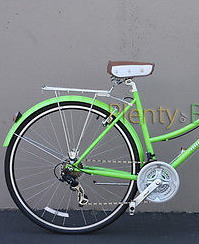

In [12]:
# load test image:
from PIL import Image
img = Image.open('./data/Stanford_Online_Products/Cropped-Photos/111085122871_0.JPG')
img

In [13]:
img_path = './data/Stanford_Online_Products/Cropped-Photos/111085122871_0.JPG'
img_dir = './data/Stanford_Online_Products/Cropped-Photos/'
img_name = '111085122871_0.JPG'
img_text_file = 'test_sample.txt'

In [14]:
# transform using same transforms that we used in the model
crop_size = 224

from torchvision import transforms
train_transform, test_transform = [], []
train_transform.extend([
        transforms.RandomResizedCrop(size=crop_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
]
)
test_transform.append(transforms.Resize((256, 256)))
test_transform.append(transforms.CenterCrop(size=224))
test_transform.append(transforms.ToTensor())
test_transform = transforms.Compose(test_transform)
train_transform = transforms.Compose(train_transform)
img_t = test_transform(img)

## original code
# query_lines   = read_file(osp.join(data_path, test_file))
# query_samples = [(osp.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in query_lines]
# query_set = ImageDataset(query_samples, transform=test_transform)

query_lines   = read_file(osp.join(data_path, img_text_file))
print(query_lines)
query_sample = [(osp.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in query_lines]
query_set = ImageDataset(query_sample, transform=test_transform)
# query_set

query_loader = DataLoader(query_set, batch_size=1, num_workers=num_workers, pin_memory=pin_memory)

query_loader.dataset.samples
model.eval()
device = next(model.parameters()).device
to_device = lambda x: x.to(device, non_blocking=True)
all_query_features, all_query_labels = [], []
all_gallery_features, all_gallery_labels = None, None

query_loader.dataset[0][0]
# with torch.no_grad():
#     for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
#         batch, labels = map(to_device, (batch, labels))
#         features = model(batch)[1]
#         all_query_labels.append(labels)
#         all_query_features.append(features)
#     all_query_labels = torch.cat(all_query_labels, 0)
#     all_query_features = torch.cat(all_query_features, 0)

['Cropped-Photos/sample_image.jpg,16743']


tensor([[[0.5255, 0.5255, 0.5294,  ..., 0.8863, 0.8863, 0.8863],
         [0.5255, 0.5255, 0.5294,  ..., 0.8863, 0.8863, 0.8863],
         [0.5294, 0.5255, 0.5255,  ..., 0.8902, 0.8902, 0.8902],
         ...,
         [0.7255, 0.7255, 0.7294,  ..., 0.3098, 0.3490, 0.4235],
         [0.7333, 0.7216, 0.7216,  ..., 0.3059, 0.3412, 0.4039],
         [0.7451, 0.7176, 0.7176,  ..., 0.3098, 0.3412, 0.3882]],

        [[0.4824, 0.4863, 0.4863,  ..., 0.8353, 0.8314, 0.8314],
         [0.4863, 0.4863, 0.4863,  ..., 0.8392, 0.8353, 0.8353],
         [0.4902, 0.4863, 0.4863,  ..., 0.8431, 0.8392, 0.8392],
         ...,
         [0.6275, 0.6196, 0.6118,  ..., 0.2353, 0.2706, 0.3490],
         [0.6353, 0.6157, 0.6078,  ..., 0.2235, 0.2549, 0.3176],
         [0.6471, 0.6118, 0.6039,  ..., 0.2157, 0.2431, 0.2902]],

        [[0.4157, 0.4118, 0.4157,  ..., 0.7725, 0.7686, 0.7686],
         [0.4157, 0.4118, 0.4157,  ..., 0.7725, 0.7725, 0.7725],
         [0.4196, 0.4118, 0.4118,  ..., 0.7765, 0.7765, 0.

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() and not cpu else 'cpu')
if cudnn_flag == 'deterministic':
    setattr(cudnn, cudnn_flag, True)
    
    
torch.manual_seed(seed)
loaders, recall_ks = get_loaders(batch_size = batch_size, test_batch_size = test_batch_size, 
        num_workers = num_workers, pin_memory = pin_memory, 
        sampler = sampler, recalls = recalls,
        num_iterations=None, 
        num_identities=None,
        train_cache_nn_inds=None,
        test_cache_nn_inds=None)
model = get_model(num_classes=loaders.num_classes,
                  arch = arch, 
                  pretrained = pretrained, 
                  num_global_features = num_global_features, 
                  norm_layer = norm_layer, 
                  detach = detach, 
                  remap = remap, 
                  normalize = normalize, 
                  normalize_weight = normalize_weight, 
                  set_bn_eval = set_bn_eval, 
                  dropout = dropout, 
                  num_local_features = num_local_features, 
                  freeze_backbone = freeze_backbone,
                  ert_seq_len = ert_seq_len,
                  ert_dim_feedforward = ert_dim_feedforward,
                  ert_nhead = ert_nhead,
                  ert_num_encoder_layers = ert_num_encoder_layers,
                  ert_dropout = ert_dropout,
                  ert_activation = ert_activation,
                  ert_normalize_before = ert_normalize_before)
# state_dict = torch.load(resume, map_location=torch.device('cpu'))
model.to(device)
model = nn.DataParallel(model)
# model.eval()

# model(img_t)
model.eval()
# query_loader=loaders.query



DataParallel(
  (module): ResNet(
    (norm_layer): Identity()
    (remap): Linear(in_features=2048, out_features=128, bias=True)
    (remap_local): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
    (dropout): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=128, out_features=11318, bias=True)
    (matcher): MatchERT(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (linear2): Linear(in_features=1024, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.0, inpla

In [16]:
def evaluate_global(model: nn.Module,
        query_loader: DataLoader,
        gallery_loader: Optional[DataLoader],
        recall_ks: List[int]):
    
    model.eval()
    device = next(model.parameters()).device
    to_device = lambda x: x.to(device, non_blocking=True)
    all_query_features, all_query_labels = [], []
    all_gallery_features, all_gallery_labels = None, None

    with torch.no_grad():
        for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
            batch, labels = map(to_device, (batch, labels))
            features = model(batch)[1]
            all_query_labels.append(labels)
            all_query_features.append(features)
        all_query_labels = torch.cat(all_query_labels, 0)
        all_query_features = torch.cat(all_query_features, 0)

        if gallery_loader is not None:
            all_gallery_features, all_gallery_labels = [], []
            for batch, labels, _ in tqdm(gallery_loader, desc='Extracting gallery features', leave=False, ncols=80):
                batch, labels = map(to_device, (batch, labels))
                features = model(batch)[1]
                all_gallery_labels.append(labels)
                all_gallery_features.append(features)
            all_gallery_labels = torch.cat(all_gallery_labels, 0)
            all_gallery_features = torch.cat(all_gallery_features, 0)

        # recall_function = partial(
        #     recall_at_ks, query_features=all_query_features, query_labels=all_query_labels, ks=recall_ks,
        #     gallery_features=all_gallery_features, gallery_labels=all_gallery_labels
        # )
        # recalls_cosine, nn_dists, nn_inds = recall_function(cosine=True)
    
    return all_query_features

In [17]:
from typing import Dict, List, Optional
import faiss, time
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F

def recall_at_ks(query_features: torch.Tensor,
                 query_labels: torch.LongTensor,
                 ks: List[int],
                 gallery_features: Optional[torch.Tensor] = None,
                 gallery_labels: Optional[torch.Tensor] = None,
                 cosine: bool = False) -> Dict[int, float]:
    """
    Compute the recall between samples at each k. This function uses about 8GB of memory.

    Parameters
    ----------
    query_features : torch.Tensor
        Features for each query sample. shape: (num_queries, num_features)
    query_labels : torch.LongTensor
        Labels corresponding to the query features. shape: (num_queries,)
    ks : List[int]
        Values at which to compute the recall.
    gallery_features : torch.Tensor
        Features for each gallery sample. shape: (num_queries, num_features)
    gallery_labels : torch.LongTensor
        Labels corresponding to the gallery features. shape: (num_queries,)
    cosine : bool
        Use cosine distance between samples instead of euclidean distance.

    Returns
    -------
    recalls : Dict[int, float]
        Values of the recall at each k.

    """
    device = query_features.device 

    offset = 0
    if gallery_features is None and gallery_labels is None:
        offset = 1
        gallery_features = query_features
        gallery_labels = query_labels
    elif gallery_features is None or gallery_labels is None:
        raise ValueError('gallery_features and gallery_labels needs to be both None or both Tensors.')

    if cosine:
        query_features = F.normalize(query_features, p=2, dim=1)
        gallery_features = F.normalize(gallery_features, p=2, dim=1)

    to_cpu_numpy = lambda x: x.cpu().numpy()
    q_f, q_l, g_f, g_l = map(to_cpu_numpy, [query_features, query_labels, gallery_features, gallery_labels])
    max_k = max(ks)

    index = faiss.IndexFlatL2(g_f.shape[1])
    # if device == torch.device(type='cpu'):
    #     index = faiss.IndexFlatL2(g_f.shape[1])
    #     # if faiss.get_num_gpus() > 0:
    #     #     index = faiss.index_cpu_to_all_gpus(index)
    # else:
    #     res = faiss.StandardGpuResources()
    #     flat_config = faiss.GpuIndexFlatConfig()
    #     flat_config.device = 0
    #     index = faiss.GpuIndexFlatL2(res, g_f.shape[1], flat_config)
    print('--------------------------------------------')
    print('FAISS initialized')
    index.add(g_f)
    print('--------------------------------------------')
    print('Index features added, start KNN searching')
    closest_dists, closest_indices = index.search(q_f, max_k + offset)
    print('--------------------------------------------')
    closest_dists = closest_dists[:,:(int(max_k) + offset)]
    closest_indices = closest_indices[:,:(int(max_k) + offset)]

    recalls = {}
    for k in ks:
        indices = closest_indices[:, offset:k + offset]
        recalls[k] = (q_l[:, None] == g_l[indices]).any(1).mean()
    return {k: round(v * 100, 2) for k, v in recalls.items()}, closest_dists[:, offset:], closest_indices[:, offset:]

In [18]:
# test_set_features = evaluate_global(model = model,
#                                     query_loader = query_loader,
#                                     gallery_loader = None,
#                                     recall_ks = recall_ks)

# pickle_save('test_set_features.pkl',test_set_features)

In [19]:
# test_set_features = pickle_load('test_set_features.pkl')
# test_set_features.shape

In [20]:
# import numpy as np
# test_image = test_set_features[0]

# (test_image - test_set_features[1]).pow(2).sum().sqrt() # euclidean distance

# dist = torch.norm(test_image - test_set_features[1], 2)
# float(dist)
# dists = []

# for i in range(test_set_features.shape[0]):
#     dists.append(float(torch.norm(test_image - test_set_features[i], 2)))

# np.argsort(dists)[:100]

# print(test_set_features[0])
# print(test_set_features[40328])

# (test_image - test_set_features[40328]).pow(2).sum().sqrt()

In [21]:
# subset_indices = [0,1,2] # select your indices here as a list
# subset = torch.utils.data.Subset(query_loader, subset_indices)
# testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

img_features = model(query_loader.dataset[0][0])[1] # features for 1 image. change first integer for different image
img_features

# model(query_loader.dataset[0][0])[1]
# need to get features for all images and save to pickle file. DONE
# then we just need to use sklearn or some other function to make one pass through data to find indexes of top n neighbors

tensor([[ 0.2591, -0.4375,  0.0162,  0.1262,  0.0312,  0.1595,  0.1325,  0.0860,
          0.0852, -0.1295, -0.3664,  0.3809, -0.0862,  0.4571,  0.2219, -0.1280,
          0.0270, -0.1844,  0.2944,  0.2847, -0.0059, -0.4385, -0.0483, -0.2767,
          0.1060,  0.5023, -0.4274,  0.1374, -0.2059, -0.1333, -0.2809, -0.1438,
          0.3116, -0.0748,  0.4448,  0.5612, -0.2002, -0.0510, -0.2353,  0.4583,
         -0.3885, -0.0801, -0.1227, -0.3801,  0.3915,  0.0449,  0.1830, -0.0712,
         -0.3356, -0.1507,  0.0990,  0.0279,  0.2080,  0.5180,  0.2342,  0.3225,
         -0.1784,  0.4401,  0.2538, -0.1319, -0.1034,  0.2979,  0.0719,  0.3796,
          0.2789, -0.2599, -0.3299, -0.0154,  0.0182,  0.0745, -0.1038,  0.2500,
          0.2841,  0.2133, -0.1271, -0.5484,  0.0422, -0.0259,  0.4463,  0.4838,
          0.2651, -0.0386,  0.2571,  0.5993,  0.0869,  0.1401,  0.4860,  0.3110,
         -0.4169, -0.5033,  0.0760, -0.1097, -0.2144, -0.1698, -0.1442,  0.1487,
         -0.5491,  0.0011, -

In [22]:
# find top n images
import numpy as np
test_set_features = pickle_load('test_set_features.pkl')


# import numpy as np
# test_image = test_set_features[0]
# (test_image - test_set_features[1]).pow(2).sum().sqrt() # euclidean distance

# dist = torch.norm(test_image - test_set_features[1], 2)
# float(dist)
dists = []

for i in range(test_set_features.shape[0]):
    dists.append(float(torch.norm(img_features - test_set_features[i], 2)))

sample_neighbors = np.argsort(dists)[:100]
sample_neighbors
# print(test_set_features[0])
# print(test_set_features[40328])

# (test_image - test_set_features[40328]).pow(2).sum().sqrt()

array([43052, 15504, 16422, 43480, 43051, 11773, 45646, 46373, 45871,
       43053, 46177, 45238, 15506, 13589, 12354, 45951, 45282, 44664,
       43639, 42590, 15501, 11772, 45115, 14140, 43216, 45236, 45293,
       45148, 44626, 43684, 43283, 44878, 44547, 43050, 45954, 44319,
       43770, 45579, 44593, 45667, 14168, 44920, 45051, 44053, 42584,
       43907, 46086, 43647, 44550, 16508, 13592, 44276, 45697, 45626,
       44923, 15206, 10822, 42773, 14758, 15502, 45279, 12696, 44360,
       46062, 43708, 46416, 44265, 43654, 46452, 45531, 46298, 43661,
       43065, 43866, 45071, 46218, 46273, 44875, 44501, 43473, 43966,
       43202, 45119, 45167, 44222, 45366, 44775, 45386, 44394, 45687,
       43657, 43284, 43766, 46429, 10845, 45038, 44299, 44718, 45645,
       16423])

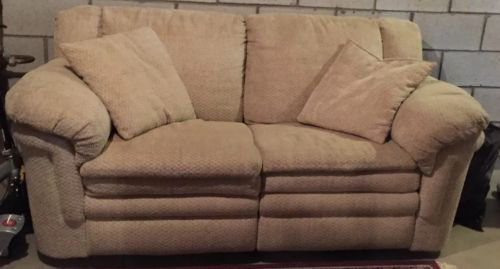

In [23]:
import pandas as pd
# make prediction using indices
def read_data(test_path):
    df = pd.read_csv(test_path,sep = ",",header = None)
    df.columns = ["FILE","CLASS"]
    file_split = df["FILE"].str.split("/", n=1, expand = True)
    df['SUPER_CLASS'] = file_split[0]
    return df

test_path = './data/Stanford_Online_Products/test.txt'
df = read_data(test_path)
df.head()
# bring up top match
top_pred = df['FILE'][sample_neighbors[0]]
top_pred
img = Image.open('./data/Stanford_Online_Products/' + top_pred)
img
# add line from test_sample to predicted_his

# move imgage to predicted


In [24]:
# add line from test_sample to predicted_his

# move imgage to predicted

In [25]:
query_loader.batch_size

1